In [2]:
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
# import seaborn as sns
# # from gensim.models import Word2Vec
# from scipy.sparse import csr_matrix
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity

In [3]:
def read_json_in_chunks(file_path, chunk_size=10000):
    """Read large JSON file in chunks"""
    chunks = []
    
    with open(file_path, 'r') as file:
        chunk = []
        for i, line in enumerate(file):
            chunk.append(line)
            
            if (i + 1) % chunk_size == 0:
                chunk_df = pd.read_json('\n'.join(chunk), lines=True)
                chunks.append(chunk_df)
                chunk = []  
        
        # process remaining lines
        if chunk:
            chunk_df = pd.read_json('\n'.join(chunk), lines=True)
            chunks.append(chunk_df)
    
    return pd.concat(chunks, ignore_index=True)

In [4]:
reviews_file_path = "data/cleaned/restaurant-reviews-cali-10.json"
reviews_df = read_json_in_chunks(reviews_file_path)
restaurants_file_path = "data/cleaned/cleaned-cali-restaurants.json"
restaurants_df = read_json_in_chunks(restaurants_file_path)

/var/folders/hp/69k970sx1pd5lx8g7p9nmhfc0000gn/T/ipykernel_14583/3573781085.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  chunk_df = pd.read_json('\n'.join(chunk), lines=True)
/var/folders/hp/69k970sx1pd5lx8g7p9nmhfc0000gn/T/ipykernel_14583/3573781085.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  chunk_df = pd.read_json('\n'.join(chunk), lines=True)
/var/folders/hp/69k970sx1pd5lx8g7p9nmhfc0000gn/T/ipykernel_14583/3573781085.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  chunk_df = pd.read_json('\n'.join(chunk), lines=True)
/var/folders/hp/69k970sx1pd5lx8g7p9nmhfc0000gn/T/ipykernel_14583/3573781085.

In [5]:
print(reviews_df.shape)
print(restaurants_df.shape)

(20908059, 6)
(83659, 15)


In [24]:
lat_min, lat_max = 37.7045, 37.8336
lon_min, lon_max = -122.527, -122.3493

sf_restaurants = restaurants_df[
    (restaurants_df["latitude"].between(lat_min, lat_max)) &
    (restaurants_df["longitude"].between(lon_min, lon_max))
]


la_gmap_ids = sf_restaurants["gmap_id"].unique()
sf_reviews = reviews_df[reviews_df["gmap_id"].isin(la_gmap_ids)]

sf_reviews.to_json('data/regional_dataset/sf/sf-reviews.json', orient='records', lines=True)
sf_restaurants.to_json('data/regional_dataset/sf/sf-restaurants.json', orient='records', lines=True)

In [26]:
sf_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 806675 entries, 92 to 20887585
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  806675 non-null  float64
 1   name     806675 non-null  object 
 2   time     806675 non-null  int64  
 3   rating   806675 non-null  int64  
 4   text     426960 non-null  object 
 5   gmap_id  806675 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 59.2+ MB


In [27]:
sf_reviews_per_user = sf_reviews["user_id"].value_counts()
sf_review_per_restaurant =  sf_reviews["gmap_id"].value_counts()

print(f"Total number of reviews: {len(sf_reviews):,}")

print(f"\nReviews per user:")
print(f"  Mean: {sf_reviews_per_user.mean():.2f}")
print(f"  Median: {sf_reviews_per_user.median():.2f}")

print(f"\nReviews per restaurant:")
print(f"  Mean: {sf_review_per_restaurant.mean():.2f}")
print(f"  Median: {sf_review_per_restaurant.median():.2f}")

Total number of reviews: 806,675

Reviews per user:
  Mean: 4.43
  Median: 2.00

Reviews per restaurant:
  Mean: 216.79
  Median: 115.00


In [40]:

# Step 1: randomly choose half of the unique users
unique_users = sf_reviews['user_id'].unique()
half_users = np.random.choice(unique_users,
                              size=len(unique_users)//3,
                              replace=False)

# Step 2: keep only reviews from those selected users
filtered_df = reviews_df[reviews_df['user_id'].isin(half_users)]

# Step 3: for each selected user, sample at most 5 reviews
sampled_df = (
    filtered_df
    .groupby('user_id', group_keys=False)
    .apply(lambda x: x.sample(n=min(5, len(x)), random_state=42))
    .reset_index(drop=True)
)

print(sampled_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294069 entries, 0 to 294068
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  294069 non-null  float64
 1   name     294069 non-null  object 
 2   time     294069 non-null  int64  
 3   rating   294069 non-null  int64  
 4   text     157125 non-null  object 
 5   gmap_id  294069 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 13.5+ MB
None


/var/folders/hp/69k970sx1pd5lx8g7p9nmhfc0000gn/T/ipykernel_14583/2518956225.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df


In [45]:
sf_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 806675 entries, 92 to 20887585
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  806675 non-null  float64
 1   name     806675 non-null  object 
 2   time     806675 non-null  int64  
 3   rating   806675 non-null  int64  
 4   text     426960 non-null  object 
 5   gmap_id  806675 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 59.2+ MB


In [60]:
sampled_df.to_json('data/sampled/sampled_sf.json', orient='records', lines=True) 

In [56]:
print(sampled_df.info())
print(sampled_df['gmap_id'].value_counts())
print(sampled_df['user_id'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281528 entries, 0 to 281527
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  281528 non-null  float64
 1   name     281528 non-null  object 
 2   time     281528 non-null  int64  
 3   rating   281528 non-null  int64  
 4   text     152463 non-null  object 
 5   gmap_id  281528 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 12.9+ MB
None
gmap_id
0x808580e3d1434971:0x8ff48dc78f89c1b9    230
0x808f7b468cecc973:0x6ea332053be5ed5f    230
0x808f7c728af258dd:0x14ff3d7b2199a99b    230
0x80858085de1e33eb:0x1a31405067f79d69    230
0x808f7e37f0d196f9:0xcf2a7b909a94bfc3    230
                                        ... 
0x80c360e750363245:0x72635abf555b7cc5      1
0x80c360e736b665ed:0x890a02fbe7ce5190      1
0x80c360e736b61bed:0x288f4549abe9869b      1
0x80c360e6bd291d1f:0xa25812d0936b8a43      1
0x89e37083704df2ed:0x44f8e6822399685a      1
Name: c

In [49]:
sampled_df = (
    sampled_df
    .groupby('user_id', group_keys=False)
    .apply(lambda x: x.sample(n=min(50, len(x)), random_state=42))
    .reset_index(drop=True)
)

/var/folders/hp/69k970sx1pd5lx8g7p9nmhfc0000gn/T/ipykernel_14583/2112506263.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df


In [50]:
print(sampled_df.info())
print(sampled_df['gmap_id'].value_counts())
print(sampled_df['user_id'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663042 entries, 0 to 663041
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  663042 non-null  float64
 1   name     663042 non-null  object 
 2   time     663042 non-null  int64  
 3   rating   663042 non-null  int64  
 4   text     360266 non-null  object 
 5   gmap_id  663042 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 30.4+ MB
None
gmap_id
0x80858085de1e33eb:0x1a31405067f79d69    1412
0x808f7b468cecc973:0x6ea332053be5ed5f     780
0x80858088632d582d:0x1ce46fa3c6d4efa0     605
0x808580e3d1434971:0x8ff48dc78f89c1b9     576
0x808f7f7178952963:0x962b020c408a387d     573
                                         ... 
0x80d76535bc0ef5ff:0xa54b335778a4e318       1
0x809ad12c7dcd165f:0xd086b0317b99c000       1
0x80c2bb6f0ad5fa2b:0xf1ed68ec44ed4ab6       1
0x80c2b417a15779c7:0xec670d7f0a91990c       1
0x80dd31d792d98185:0x3e62c6f2702fbecf     

In [43]:
unique_users = sampled_sf_reviews['user_id'].unique()

In [ ]:
sampled_restaurants['']

<class 'pandas.core.frame.DataFrame'>
Index: 3721 entries, 8 to 83630
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3721 non-null   object 
 1   address           3721 non-null   object 
 2   gmap_id           3721 non-null   object 
 3   description       2995 non-null   object 
 4   latitude          3721 non-null   float64
 5   longitude         3721 non-null   float64
 6   category          3721 non-null   object 
 7   avg_rating        3721 non-null   float64
 8   num_of_reviews    3721 non-null   int64  
 9   price             3063 non-null   object 
 10  hours             3543 non-null   object 
 11  MISC              3684 non-null   object 
 12  state             2565 non-null   object 
 13  relative_results  3549 non-null   object 
 14  url               3721 non-null   object 
dtypes: float64(3), int64(1), object(11)
memory usage: 594.2+ KB


In [34]:
sampled_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3721 entries, 8 to 83630
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3721 non-null   object 
 1   address           3721 non-null   object 
 2   gmap_id           3721 non-null   object 
 3   description       2995 non-null   object 
 4   latitude          3721 non-null   float64
 5   longitude         3721 non-null   float64
 6   category          3721 non-null   object 
 7   avg_rating        3721 non-null   float64
 8   num_of_reviews    3721 non-null   int64  
 9   price             3063 non-null   object 
 10  hours             3543 non-null   object 
 11  MISC              3684 non-null   object 
 12  state             2565 non-null   object 
 13  relative_results  3549 non-null   object 
 14  url               3721 non-null   object 
dtypes: float64(3), int64(1), object(11)
memory usage: 594.2+ KB


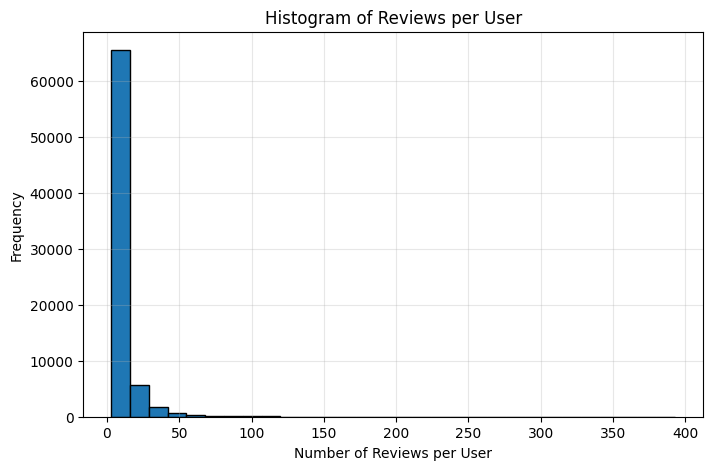

In [29]:
plt.figure(figsize=(8, 5))
plt.hist(sf_reviews_per_user[sf_reviews_per_user>2], bins=30, edgecolor='black')  # adjust bins as needed
plt.xlabel('Number of Reviews per User')
plt.ylabel('Frequency')
plt.title('Histogram of Reviews per User')
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
reviews_per_user = la_reviews["user_id"].value_counts()

In [11]:
print(reviews_per_user.mean())
print(reviews_per_user.median())

10.65760151660025
6.0


In [12]:
review_per_restaurant = la_reviews["gmap_id"].value_counts()

In [16]:

la_restaurants.to_json('data/regional_dataset/la-restaurants.json', orient='records', lines=True)

In [20]:
la_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31410 entries, 0 to 83658
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              31410 non-null  object 
 1   address           31382 non-null  object 
 2   gmap_id           31410 non-null  object 
 3   description       19475 non-null  object 
 4   latitude          31410 non-null  float64
 5   longitude         31410 non-null  float64
 6   category          31410 non-null  object 
 7   avg_rating        31410 non-null  float64
 8   num_of_reviews    31410 non-null  int64  
 9   price             24375 non-null  object 
 10  hours             30497 non-null  object 
 11  MISC              31314 non-null  object 
 12  state             22431 non-null  object 
 13  relative_results  30140 non-null  object 
 14  url               31410 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 4.8+ MB


In [18]:
print(f"Total number of reviews: {len(gcm_reviews):,}")

print(f"\nReviews per user:")
print(f"  Mean: {reviews_per_user.mean():.2f}")
print(f"  Median: {reviews_per_user.median():.2f}")

print(f"\nReviews per restaurant:")
print(f"  Mean: {review_per_restaurant.mean():.2f}")
print(f"  Median: {review_per_restaurant.median():.2f}")

Total number of reviews: 0

Reviews per user:
  Mean: nan
  Median: nan

Reviews per restaurant:
  Mean: 245.56
  Median: 128.00


In [14]:
print(f"Total number of reviews: {len(la_reviews):,}")

print(f"\nReviews per user:")
print(f"  Mean: {reviews_per_user.mean():.2f}")
print(f"  Median: {reviews_per_user.median():.2f}")

print(f"\nReviews per restaurant:")
print(f"  Mean: {review_per_restaurant.mean():.2f}")
print(f"  Median: {review_per_restaurant.median():.2f}")

Total number of reviews: 7,713,162

Reviews per user:
  Mean: 10.66
  Median: 6.00

Reviews per restaurant:
  Mean: 245.56
  Median: 128.00


In [52]:
filtered_ids = total_restaurant_count.index
filtered_ids
filtered_restaurant_df = restaurants_meta_df[restaurants_meta_df["gmap_id"].isin(filtered_ids)]

In [54]:
filtered_restaurant_df = filtered_restaurant_df.drop_duplicates(subset=['gmap_id'])
filtered_restaurant_df.shape

(83659, 15)

In [55]:
filtered_restaurant_df.to_json("data/cleaned-cali-restaurants.json", orient="records" ,lines=True)

In [45]:
total_user_count = reviews_df["user_id"].value_counts()
total_restaurant_count = reviews_df["gmap_id"].value_counts()

In [42]:
total_restaurant_count.describe()

count    83659.000000
mean       249.920021
std        358.849561
min         10.000000
25%         55.000000
50%        137.000000
75%        314.000000
max       8437.000000
Name: count, dtype: float64

In [ ]:
lat_min, lat_max = 37.7045, 37.8336
lon_min, lon_max = -122.527, -122.3493

sf_restaurants = restaurants_meta_df[
    (restaurants_meta_df["latitude"].between(lat_min, lat_max)) &
    (restaurants_meta_df["longitude"].between(lon_min, lon_max))
]

In [13]:
sf_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4220 entries, 250 to 515831
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              4220 non-null   object 
 1   address           4219 non-null   object 
 2   gmap_id           4220 non-null   object 
 3   description       3166 non-null   object 
 4   latitude          4220 non-null   float64
 5   longitude         4220 non-null   float64
 6   category          4220 non-null   object 
 7   avg_rating        4220 non-null   float64
 8   num_of_reviews    4220 non-null   int64  
 9   price             3263 non-null   object 
 10  hours             3945 non-null   object 
 11  MISC              4183 non-null   object 
 12  state             2959 non-null   object 
 13  relative_results  3858 non-null   object 
 14  url               4220 non-null   object 
dtypes: float64(3), int64(1), object(11)
memory usage: 527.5+ KB


In [2]:
sf_gmap_ids = sf_restaurants["gmap_id"].unique()
len(sf_gmap_ids)

NameError: name 'sf_restaurants' is not defined

In [ ]:

reviews_df = read_json_in_chunks("restaurant-reviews-cali.json")

In [ ]:
reviews_df.shape

(20908059, 6)

In [22]:
sf_reviews_df = reviews_df[reviews_df["gmap_id"].isin(sf_gmap_ids)]
sf_reviews_df.shape

(806675, 6)

In [ ]:
sf_reviews_per_user = sf_reviews_df["user_id"].value_counts()
#stats
print("Total users:", sf_reviews_per_user.shape)

print("Average reviews per user:", sf_reviews_per_user.mean())
print("Median reviews per user:", sf_reviews_per_user.median())

Total users: (182297,)
Average reviews per user: 4.425059106842132
Median reviews per user: 2.0


In [1]:
sf_reviews_per_restaurant = sf_reviews_df["gmap_id"].value_counts()
#stats
print("SF restaurants:", sf_reviews_per_restaurant.shape)
print("Average reviews per restaurant:", sf_reviews_per_restaurant.mean())
print("Median reviews per restaurant:", sf_reviews_per_restaurant.median())

NameError: name 'sf_reviews_df' is not defined

In [ ]:
lat_min, lat_max = 33.70365, 34.33730
lon_min, lon_max = -118.66818, -118.15529

la_restaurants = restaurants_meta_df[
    (restaurants_meta_df["latitude"].between(lat_min, lat_max)) &
    (restaurants_meta_df["longitude"].between(lon_min, lon_max))
]

In [37]:
meta_df["address"].head().to_string()

'0    San Soo Dang, 761 S Vermont Ave, Los Angeles, ...\n1    Vons Chicken, 12740 La Mirada Blvd, La Mirada,...\n2    TACOS LA CABANA, 2015 22nd Ave, Oakland, CA 94606\n3    Mariscos el poblano, 5401-5441 Coliseum Way, O...\n4      Off The Hoof, 201 E 4th St, Santa Ana, CA 92701'

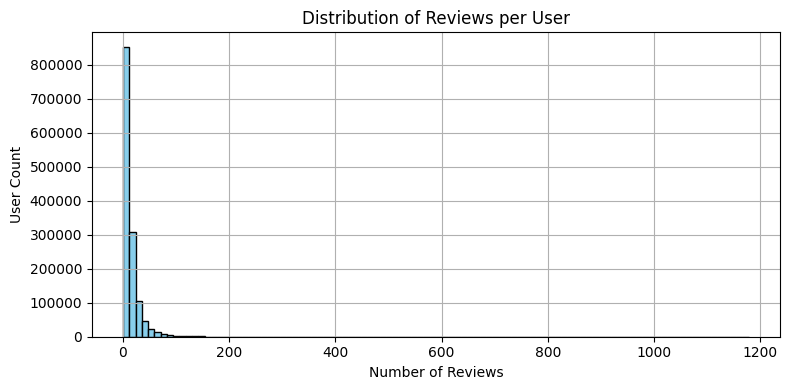

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(reviews_per_user, bins = 100, color='skyblue', edgecolor='black')
plt.title('Distribution of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('User Count')18.
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
reviews_per_user.describe()

count    1.366552e+06
mean     1.529986e+01
std      1.832819e+01
min      1.000000e+00
25%      6.000000e+00
50%      1.000000e+01
75%      1.800000e+01
max      1.178000e+03
Name: count, dtype: float64

In [19]:
review_per_restaurant = reviews_df["gmap_id"].value_counts()
review_per_restaurant.describe()
print("Total restaurants:", review_per_restaurant.shape[0])
print("Average reviews per restaurants:", review_per_restaurant.mean())
print("Median reviews per restaurants:", review_per_restaurant.median())

Total restaurants: 83659
Average reviews per restaurants: 249.92002055965287
Median reviews per restaurants: 137.0


In [20]:
review_per_restaurant.describe()

count    83659.000000
mean       249.920021
std        358.849561
min         10.000000
25%         55.000000
50%        137.000000
75%        314.000000
max       8437.000000
Name: count, dtype: float64

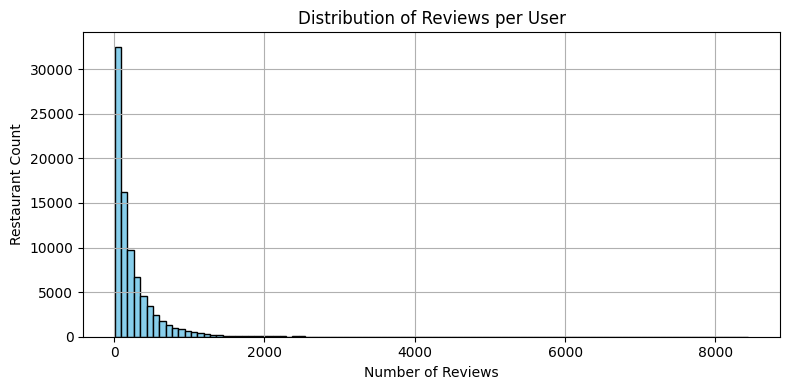

In [21]:
plt.figure(figsize=(8,4))
plt.hist(review_per_restaurant, bins = 100, color='skyblue', edgecolor='black')
plt.title('Distribution of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Restaurant Count')
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
restaurants_with_0_reviews = set(unique_gmap_ids) - set(review_per_restaurant.index)

In [23]:
print(len(unique_gmap_ids))
len(restaurants_with_0_reviews)

92544


8885

In [ ]:
sf_meta_df = meta_df[meta_df['address'].str.contains('San Francisco', case=False, na=False)]
len(sf_meta_df)

4417

In [26]:
sd_reviews_df = reviews_df[reviews_df["gmap_id"].isin(sf_meta_df["gmap_id"])]
len(sd_reviews_df)

842886

In [27]:
sf_user_count = sd_reviews_df["user_id"].value_counts()
sf_user_count.describe()

count    189923.000000
mean          4.438041
std           8.851343
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         397.000000
Name: count, dtype: float64

In [28]:
restaurant_user_count = sd_reviews_df["gmap_id"].value_counts()
restaurant_user_count.describe()

count    3895.000000
mean      216.402054
std       324.535283
min        10.000000
25%        44.000000
50%       116.000000
75%       256.000000
max      7534.000000
Name: count, dtype: float64

In [ ]:
lat_min, lat_max = 33.70365, 34.33730
lon_min, lon_max = -118.66818, -118.15529

la_restaurants = restaurants_meta_df[
    (restaurants_meta_df["latitude"].between(lat_min, lat_max)) &
    (restaurants_meta_df["longitude"].between(lon_min, lon_max))
]
# Filter reviews for LA restaurants
la_reviews_df = reviews_df[reviews_df["gmap_id"].isin(la_restaurants["gmap_id"])]

# User and restaurant counts
la_user_count = la_reviews_df["user_id"].value_counts()
la_restaurant_count = la_reviews_df["gmap_id"].value_counts()

# Nicely formatted output
print("📍 Los Angeles Data Summary")
print("-" * 40)
print(f"Number of restaurants in LA : {len(la_restaurants)}")
print(f"Number of reviews in LA     : {len(la_reviews_df)}")
print(f"Unique users in LA          : {la_user_count.nunique()}")
print(f"Unique restaurants in LA    : {la_restaurant_count.nunique()}")
print()
print("Top 5 most active users:")
print(la_user_count.head().to_string())
print()
print("Top 5 most reviewed restaurants:")
print(la_restaurant_count.head().to_string())


📍 Los Angeles Data Summary
----------------------------------------


NameError: name 'la_meta_df' is not defined

In [29]:
print("📍 Los Angeles Data Summary")
print("-" * 40)
print(f"Number of restaurants in LA : {len(la_restaurants)}")
print(f"Number of reviews in LA     : {len(la_reviews_df)}")
print(f"Unique users in LA          : {len(la_user_count)}")
print(f"Unique restaurants in LA    : {len(la_restaurant_count)}")
print()
print("Top 5 most active users:")
print(la_user_count.head().to_string())
print()
print("Top 5 most reviewed restaurants:")
print(la_restaurant_count.head().to_string())

📍 Los Angeles Data Summary
----------------------------------------
Number of restaurants in LA : 17300
Number of reviews in LA     : 3694744
Unique users in LA          : 497724
Unique restaurants in LA    : 15227

Top 5 most active users:
user_id
1.100327e+20    722
1.056125e+20    440
1.032846e+20    402
1.125449e+20    386
1.183643e+20    376

Top 5 most reviewed restaurants:
gmap_id
0x80c29c18728fd735:0x6956afd57fd182f8    7801
0x80c2b754b4646eb1:0x9903ae1f52e0e715    7735
0x80c2bb8cf4aac185:0x9d11acb5cb57c5b3    7420
0x80c2c054f6a8805d:0xe621dcbff857a957    7232
0x80c29581d2fc8333:0x2bbe1a28d46a2726    7028


In [31]:
la_reviews_df.shape

(3694744, 6)

In [ ]:
la_restaurant_count.describe()

count    15227.000000
mean       242.644250
std        382.096548
min         10.000000
25%         46.000000
50%        121.000000
75%        294.000000
max       7801.000000
Name: count, dtype: float64

Filter SF by zip code

In [30]:
la_user_count.describe()

count    497724.000000
mean          7.423279
std          11.861931
min           1.000000
25%           1.000000
50%           4.000000
75%           8.000000
max         722.000000
Name: count, dtype: float64